### Download and load libraries

In [ ]:
!pip install spacy==2.3.2
!python -m spacy download pl_core_news_sm
!pip install langdetect
!pip install -U yellowbrick
!pip install eli5
!pip install -U scikit-learn==0.23.2

     |████████████████████████████████| 10.0MB 6.9MB/s 
     |████████████████████████████████| 2.1MB 49.5MB/s 
  Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4
     |████████████████████████████████| 48.7MB 1.4MB/s 
  Created wheel for pl-core-news-sm: filename=pl_core_news_sm-2.3.0-cp36-none-any.whl size=48719489 sha256=572d0fcacb5b2203152f1f103a8b5b7b3e24be22c3c5ff760eb4d06346ec50ca
  Stored in directory: /tmp/pip-ephem-wheel-cache-jbvz22ha/wheels/ce/7a/53/aab09c53056da9fefa67b44d57202e9bd556825e12ca89fff1
Successfully built pl-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('pl_core_news_sm')
     |████████████████████████████████| 983kB 7.9MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp36-none-any.whl size=993195 sha256=edaeb7c29c9312ddd

In [ ]:
import spacy
import pandas as pd
from IPython.display import clear_output
from langdetect import detect
#https://spacy.io/universe/project/spacy-streamlit

## Clean data

In [ ]:
text = pd.read_csv('https://storage.googleapis.com/poleval_data/training_set_clean_only_text.txt', sep="\n", header=None, names=['text'], encoding='utf-8')
tag = pd.read_csv('https://storage.googleapis.com/poleval_data/training_set_clean_only_tags.txt', sep="\n", header=None, names=['tag'], encoding='utf-8')
print(text.shape)

def clean_data(data):
  data = data.replace(r'\\n',' ', regex=True)
  data = data.replace(r'\n',' ', regex=True)
  data['text'] = data['text'].str.replace('\d+', '')
  data.text.replace('@anonymized_account', '', regex=True, inplace=True)
  data.text.replace('#NAME?', '', regex=True, inplace=True)
  return data

(10041, 1)


In [ ]:
from spacy.lang.pl.stop_words import STOP_WORDS
# Parser for reviews
print("load corpus")
try:
  parser
except NameError:
  parser = spacy.load('pl_core_news_sm')
print('corpus loaded succesfully')
def spacy_tokenizer(mytokens):
    mytokens = [word for word in mytokens if
                word.is_punct == False and word.is_stop == False
                and len(word) > 3 
                and word.like_num == False 
                and word.is_currency == False 
                and word.like_email == False]
    mytokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

load corpus
corpus loaded succesfully


In [ ]:
data = pd.concat([text, tag], axis=1)
data = clean_data(data)

In [ ]:
from tqdm.auto import tqdm
tokens = list()
for doc in tqdm(parser.pipe(data['text'].astype('unicode').values, batch_size=100,
                        n_threads=10)):
  tokens.append(spacy_tokenizer(doc))

# because it couse problem drop index 4081
data["processed_text"] = tokens
data = data.drop(data.index[[4081]])
data = data[~(data.processed_text.str.len() < 10)]
tqdm.pandas()
data = data[data.processed_text.progress_apply(lambda x: detect(x) == 'pl')]

In [ ]:
data.sample(100).to_json('./test_case_parse_text.json')

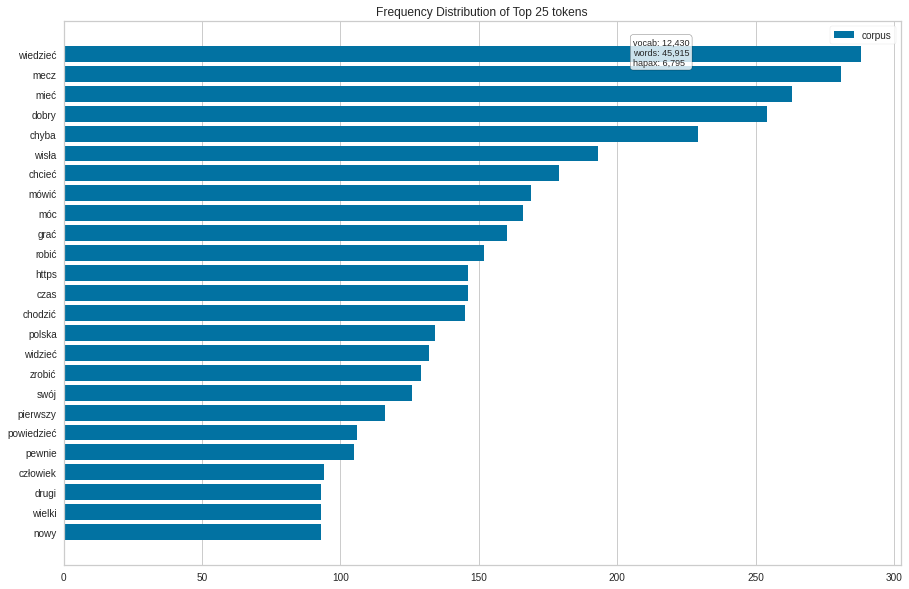

In [ ]:
#@title Word Cloud grouped by type of harmfulness { run: "auto", vertical-output: true, display-mode: "form" }
tweets = "non-harmful" #@param ["non-harmful", "cyberbullying", "hate-speech"]
plot_type = "Frequency Visualizer" #@param ["Word Cloud", "Frequency Visualizer", "Class Balance"]
tweet_dict = dict(zip(["non-harmful", "cyberbullying", "hate-speech"], [0,1,2]))

import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.target import ClassBalance
from spacy.lang.pl import STOP_WORDS
from yellowbrick import text

def plot_data(data: np.array, plot_type: str) -> None:
  if plot_type == 'Word Cloud':
    wordcloud = WordCloud(
        width = 300,
        height = 200,
        background_color = 'black').generate(str(data))
    fig = plt.figure(
        figsize = (10, 15),
        facecolor = 'k',
        edgecolor = 'k')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()
  elif plot_type == 'Frequency Visualizer':
    vectorizer = CountVectorizer(stop_words=STOP_WORDS)
    docs = vectorizer.fit_transform(data)
    features = vectorizer.get_feature_names()
    plt.rcParams['figure.figsize'] = 15, 10
    visualizer = text.FreqDistVisualizer(features=features, orient='h', n=25)
    visualizer.fit(docs)
    visualizer.poof()
  elif plot_type == 'Class Balance':
    visualizer = ClassBalance(labels=["non-harmful", "cyberbullying", "hate-speech"])
    visualizer.fit(data.tag)
    visualizer.show()

if plot_type == 'Class Balance':
  doc = data
else:
  doc = data[data.tag == tweet_dict[tweets]].processed_text.values

plot_data(doc, plot_type)
  

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


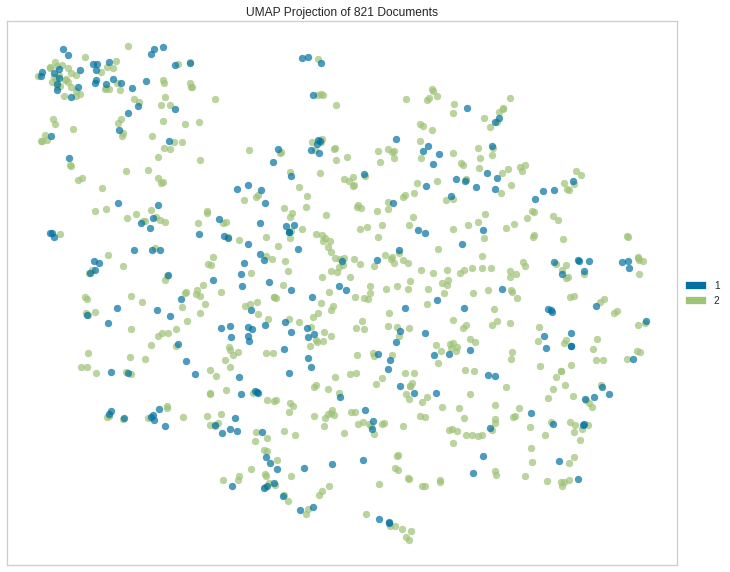

In [ ]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

from yellowbrick.text import umap

tfidf = TfidfVectorizer()
X = data[data.tag != 0]
docs = tfidf.fit_transform(X.processed_text)
labels = X.tag

# Instantiate the text visualizer
umap = UMAPVisualizer(metric='cosine')
umap.fit(docs, labels)
umap.show()

## Modeling part

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_selection import SelectPercentile, f_classif, chi2
from sklearn.svm import SVC
# Logistic Regression Classifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import warnings

warnings.filterwarnings("ignore")

# Create pipeline using Bag of Words
pipe = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('selector', SelectPercentile(chi2, percentile=50)),
                ('clf', LogisticRegression(n_jobs=1, C=1e5, max_iter=100, solver='liblinear', dual=True, random_state=23)),
               ])


X_train = data['processed_text'].values # the features we want to analyze
y_train = data['tag'].values # the labels, or answers, we want to test against

print(X_train.shape, y_train.shape)
# model generation
from sklearn.model_selection import cross_val_score
from sklearn import metrics

def getScores(estimator, x, y):
    yPred = estimator.predict(x)
    return (metrics.accuracy_score(y, yPred), 
            metrics.f1_score(y, yPred, average='micro'), 
            metrics.f1_score(y, yPred, average='macro'))

def my_scorer(estimator, x, y):
    a, p, r = getScores(estimator, x, y)
    print("Accuracy: {} | F1 micro: {} | F1 macro: {}".format(a, p, r))
    return a+p+r
  
scores = cross_val_score(pipe, X_train, y_train, scoring=my_scorer, cv=10)

(9214,) (9214,)
Accuracy: 0.8980477223427332 | F1 micro: 0.8980477223427332 | F1 macro: 0.42976068296150843
Accuracy: 0.8969631236442517 | F1 micro: 0.8969631236442517 | F1 macro: 0.4471051262034869
Accuracy: 0.8893709327548807 | F1 micro: 0.8893709327548807 | F1 macro: 0.44110099404217046
Accuracy: 0.8937093275488069 | F1 micro: 0.8937093275488069 | F1 macro: 0.3998030643191934
Accuracy: 0.9044516829533116 | F1 micro: 0.9044516829533116 | F1 macro: 0.42807319797869287
Accuracy: 0.8990228013029316 | F1 micro: 0.8990228013029317 | F1 macro: 0.4911252219825814
Accuracy: 0.8990228013029316 | F1 micro: 0.8990228013029317 | F1 macro: 0.4422804251787585
Accuracy: 0.8849077090119435 | F1 micro: 0.8849077090119435 | F1 macro: 0.3885114677947825
Accuracy: 0.8946796959826275 | F1 micro: 0.8946796959826275 | F1 macro: 0.38921151116273073
Accuracy: 0.9001085776330076 | F1 micro: 0.9001085776330076 | F1 macro: 0.46005972471297957


In [ ]:
# Fit pipe with a train dataset
pipe.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('selector',
                 SelectPercentile(percentile=50,
                                  score_func=<function chi2 at 0x7f55bdac1048>)),
                ('clf',
                 LogisticRegression(C=100000.0, dual=True, n_jobs=1,
                                    random_state=23, solver='liblinear'))])

In [ ]:
# test 
text_test = pd.read_csv('https://storage.googleapis.com/poleval_data/test_set_only_text.txt', sep="\n", header=None, names=['text'], encoding='utf-8')
tag_test = pd.read_csv('https://storage.googleapis.com/poleval_data/test_set_only_tags.txt', sep="\n", header=None, names=['tag'], encoding='utf-8')

data_test = pd.concat([text_test, tag_test], axis=1)

d_comp = data_test.copy()
# d_comp = d_comp.text.str.replace('@anonymized_account', '')
d_comp = clean_data(d_comp)
# data = data[data.text.apply(lambda x: detect(x) == 'pl')]

d_comp.shape, data_test.shape

((1000, 2), (1000, 2))

In [ ]:
d_comp.head()

,text,tag
0,"Spoko, jak im Duda z Morawieckim zamówią po p...",0
1,"Ale on tu nie miał szans jej zagrania, a ta ...",0
2,"No czy Prezes nie miał racji, mówiąc,ze to są...",0
3,Przecież to nawet nie jest przewrotka 😂,0
4,Owszem podatki tak. Ale nie w takich okolicz...,0


In [ ]:
tokens = list()
for doc in tqdm(parser.pipe(d_comp['text'].astype('unicode').values, batch_size=100,
                        n_threads=5)):
  tokens.append(spacy_tokenizer(doc))

d_comp["processed_text"] = tokens

d_comp.shape

(1000, 3)

In [ ]:
# predicted = pipe.predict(d_comp["processed_text"].values)
predicted = np.argmax(pipe.predict_proba(d_comp["processed_text"].values), axis=1)
y_test_dev = d_comp['tag']

In [ ]:
# dummy predictor
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
predicted_dumy = dummy_clf.predict(d_comp["processed_text"].values)
print("Dummy classifier Accuracy:",metrics.accuracy_score(y_test_dev, predicted_dumy))
print("Dummy classifier F1 micro:",metrics.f1_score(y_test_dev, predicted_dumy, average='micro'))
print("Dummy classifier F1 macro:",metrics.f1_score(y_test_dev, predicted_dumy, average='macro'))

Dummy classifier Accuracy: 0.866
Dummy classifier F1 micro: 0.866
Dummy classifier F1 macro: 0.3093962129331904


In [ ]:
# Model Accuracy
print(predicted.shape)
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test_dev, predicted))
print("Logistic Regression F1 micro:",metrics.f1_score(y_test_dev, predicted, average='micro'))
print("Logistic Regression F1 macro:",metrics.f1_score(y_test_dev, predicted, average='macro'))

(1000,)
Logistic Regression Accuracy: 0.875
Logistic Regression F1 micro: 0.875
Logistic Regression F1 macro: 0.48002842928216066


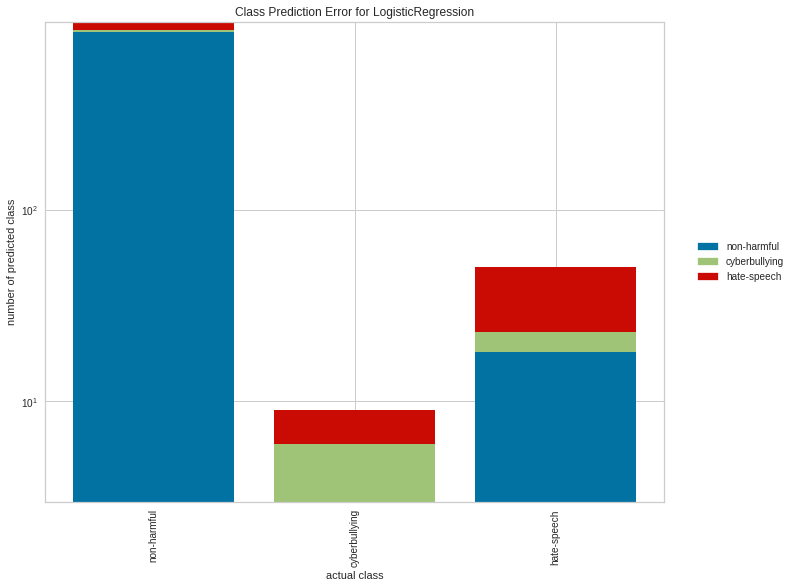

In [ ]:
#@title Model Explain { run: "auto", vertical-output: true }
plot_type = "Class Prediction Error" #@param ["Classification Report", "Confusion Matrix", "ROCAUC", "Class Prediction Error"]

import matplotlib.pyplot as plt
from yellowbrick.classifier import ClassificationReport, ConfusionMatrix, ROCAUC, ClassPredictionError

classes = ["non-harmful", "cyberbullying", "hate-speech"]

def visualize_model(X, y, estimator, plot_type):

    if plot_type == 'Classification Report':
      visualizer = ClassificationReport(estimator, support=True, classes = classes,
                                        cmap="YlGn", size=(900, 600))

    elif plot_type == 'Confusion Matrix':
      visualizer = ConfusionMatrix(estimator, classes=classes,
                                   cmap="YlGn", size=(900, 600))

    elif plot_type == 'ROCAUC':
      visualizer = ROCAUC(estimator, classes=classes,
                          cmap="YlGn", size=(900, 600))

    elif plot_type == 'Class Prediction Error':
      visualizer = ClassPredictionError(estimator, classes=classes,
                                        cmap="YlGn", size=(900, 600))
      plt.yscale('log')
    visualizer.score(X, y)
    visualizer.poof()


visualize_model(d_comp["processed_text"].values, y_test_dev, pipe, plot_type)

In [ ]:
import eli5
from eli5.lime import TextExplainer

te = TextExplainer(random_state=42)
te.fit(d_comp["processed_text"].values[24], pipe.predict_proba)
te.show_prediction(target_names=['d', 's', 'f'])

In [ ]:
import eli5
from eli5.lime import TextExplainer

te = TextExplainer(random_state=42)
te.fit(d_comp["processed_text"].values[24], pipe.predict_proba)
te.show_prediction(target_names=['d', 's', 'f'])

## save model

In [ ]:
import joblib
# save the model to disk
filename = 'regression_pipeline_exp0.sav'
joblib.dump(pipe, filename)

['regression_pipeline_exp0.sav']